### [Implementing the Relative Vigor Index and Backtesting a Trading Strategy with Python](https://medium.com/codex/implementing-the-relative-vigor-index-and-backtesting-a-trading-strategy-with-python-d317afc0923a)

**Relative Vigor Index (RVI)** <br>
相對活力指數是一種動量指標，可作為確定當前市場動能（向上或向下）的工具。 <br>
與隨機震盪指標不同，相對活力指數是一個無界震盪指標，不會在特定閾值之間波動，而是在中線（大多數情況下為零）上震盪。相對活力指數由兩部分組成，即 RVI 線和信號線。

In [12]:
# IMPORTING PACKAGES

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from termcolor import colored as cl
from math import floor
import yfinance as yf
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt


plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [16]:
# get stock prices using yfinance library
def get_stock_price(symbol):
  df = yf.download(symbol, start='2019-01-01', threads= False)
  df['Date'] = pd.to_datetime(df.index)
  df['Date'] = df['Date'].apply(mpl_dates.date2num)
  df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
  df.columns = ['open','high','low','close','volume']
  return df

symbol = 'AAPL'
df = get_stock_price(symbol)

[*********************100%***********************]  1 of 1 completed


In [17]:
aapl = df
aapl.tail()

,open,high,low,close,volume
Date,,,,,
2022-08-29,19233.0,161.149994,162.899994,159.820007,161.380005
2022-08-30,19234.0,162.130005,162.559998,157.720001,158.910004
2022-08-31,19235.0,160.309998,160.580002,157.139999,157.220001
2022-09-01,19236.0,156.639999,158.419998,154.669998,157.960007
2022-09-02,19237.0,159.750000,160.360001,154.970001,155.809998


In [18]:
# RELATIVE VIGOR INDEX CALCULATION

def get_rvi(open, high, low, close, lookback):
    a = close - open
    b = 2 * (close.shift(2) - open.shift(2))
    c = 2 * (close.shift(3) - open.shift(3))
    d = close.shift(4) - open.shift(4)
    numerator = a + b + c + d
    
    e = high - low
    f = 2 * (high.shift(2) - low.shift(2))
    g = 2 * (high.shift(3) - low.shift(3))
    h = high.shift(4) - low.shift(4)
    denominator = e + f + g + h
    
    numerator_sum = numerator.rolling(4).sum()
    denominator_sum = denominator.rolling(4).sum()
    rvi = (numerator_sum / denominator_sum).rolling(lookback).mean()
    
    rvi1 = 2 * rvi.shift(1)
    rvi2 = 2 * rvi.shift(2)
    rvi3 = rvi.shift(3)
    rvi_signal = (rvi + rvi1 + rvi2 + rvi3) / 6
    
    return rvi, rvi_signal

aapl['rvi'], aapl['signal_line'] = get_rvi(aapl['open'], aapl['high'], aapl['low'], aapl['close'], 10)
aapl = aapl.dropna()
aapl = aapl[aapl.index >= '2020-01-01']
aapl.tail()

,open,high,low,close,volume,rvi,signal_line
Date,,,,,,,
2022-08-29,19233.0,161.149994,162.899994,159.820007,161.380005,13676.626935,12312.723674
2022-08-30,19234.0,162.130005,162.559998,157.720001,158.910004,14424.298346,13188.513226
2022-08-31,19235.0,160.309998,160.580002,157.139999,157.220001,15215.563570,14031.717510
2022-09-01,19236.0,156.639999,158.419998,154.669998,157.960007,15877.967705,14805.719745
2022-09-02,19237.0,159.750000,160.360001,154.970001,155.809998,16936.568552,15591.321575


In [19]:
# RELATIVE VIGOR INDEX STRATEGY

def implement_rvi_strategy(prices, rvi, signal_line):
    buy_price = []
    sell_price = []
    rvi_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if rvi[i-1] < signal_line[i-1] and rvi[i] > signal_line[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rvi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rvi_signal.append(0)
        elif rvi[i-1] > signal_line[i-1] and rvi[i] < signal_line[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rvi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rvi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rvi_signal.append(0)
            
    return buy_price, sell_price, rvi_signal

buy_price, sell_price, rvi_signal = implement_rvi_strategy(aapl['close'], aapl['rvi'], aapl['signal_line'])

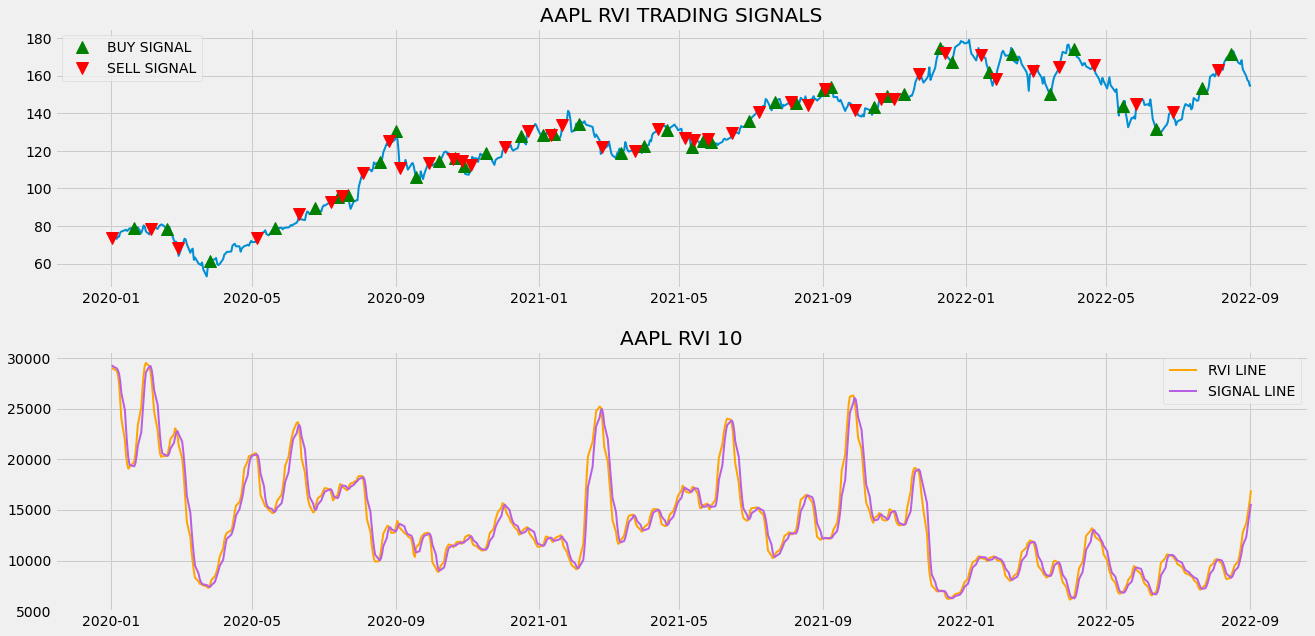

In [20]:
# RELATIVE VIGOR INDEX TRADING SIGNALS PLOT

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(aapl['close'], linewidth = 2)
ax1.plot(aapl.index, buy_price, marker = '^', markersize = 12, color = 'green', linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(aapl.index, sell_price, marker = 'v', markersize = 12, color = 'r', linewidth = 0, label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('AAPL RVI TRADING SIGNALS')
ax2.plot(aapl['rvi'], linewidth = 2, color = 'orange', label = 'RVI LINE')
ax2.plot(aapl['signal_line'], linewidth = 2, color = '#BA5FE3', label = 'SIGNAL LINE')
ax2.set_title('AAPL RVI 10')
ax2.legend()
plt.show()

In [21]:
# STOCK POSITION

position = []
for i in range(len(rvi_signal)):
    if rvi_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl['close'])):
    if rvi_signal[i] == 1:
        position[i] = 1
    elif rvi_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = aapl['close']
rvi = aapl['rvi']
signal_line = aapl['signal_line']
rvi_signal = pd.DataFrame(rvi_signal).rename(columns = {0:'rvi_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'rvi_position'}).set_index(aapl.index)

frames = [close_price, rvi, signal_line, rvi_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,rvi,signal_line,rvi_signal,rvi_position
Date,,,,,
2020-01-02,73.797501,29037.753974,29294.709993,-1,0
2020-01-03,74.125000,28919.028525,29148.563909,0,0
2020-01-06,73.187500,28753.918354,28977.476092,0,0
2020-01-07,74.370003,28387.384037,28795.171961,0,0
2020-01-08,74.290001,27539.128769,28456.793679,0,0
...,...,...,...,...,...
2022-08-29,159.820007,13676.626935,12312.723674,0,1
2022-08-30,157.720001,14424.298346,13188.513226,0,1
2022-08-31,157.139999,15215.563570,14031.717510,0,1


In [22]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(aapl['close'])).rename(columns = {0:'returns'})
rvi_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['rvi_position'][i]
    rvi_strategy_ret.append(returns)
    
rvi_strategy_ret_df = pd.DataFrame(rvi_strategy_ret).rename(columns = {0:'rvi_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/aapl['close'][0])
rvi_investment_ret = []

for i in range(len(rvi_strategy_ret_df['rvi_returns'])):
    returns = number_of_stocks*rvi_strategy_ret_df['rvi_returns'][i]
    rvi_investment_ret.append(returns)

rvi_investment_ret_df = pd.DataFrame(rvi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(rvi_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the RVI strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RVI strategy : {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RVI strategy by investing $100k in AAPL : 55897.14
Profit percentage of the RVI strategy : 55%


In [25]:
# SPY ETF COMPARISON

def get_benchmark(start_date, investment_value):
    spy = get_stock_price('SPY')['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)
investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('RVI Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))

[*********************100%***********************]  1 of 1 completed
Benchmark profit by investing $100k : 57715.43
Benchmark Profit percentage : 57%
RVI Strategy profit is -2% higher than the Benchmark Profit
